In [2]:
import numpy as np
np.set_printoptions(precision=6,suppress=True)
from triqs.plot.mpl_interface import plt,oplot

from h5 import HDFArchive
from triqs.gf import BlockGf

from triqs_dft_tools.converters.vasp import VaspConverter 
import triqs_dft_tools.converters.plovasp.converter as plo_converter

import pymatgen.io.vasp.outputs as vio
from pymatgen.electronic_structure.dos import CompleteDos
from pymatgen.electronic_structure.core import Spin, Orbital, OrbitalType

import warnings 
warnings.filterwarnings("ignore") #ignore some matplotlib warnings

Starting serial run at: 2022-02-25 08:11:24.095391


# AFM state of NiO with one-shot DMFT from Vasp

In this tutorial we will take a look at a magnetic DMFT calculation for NiO in the antiferromagnetic phase. This tutorial will guide you through the following steps: 

* run a non-magnetic Vasp calculation for NiO with a two atom unit cel
* create projectors in a large energy window for all Ni-$d$ orbitals and all O-$p$ orbitals
* create the hdf5 input via the Vasp converter for solid_dmft
* run a high temperature paramagnetic calculation and a low temperature AFM calculation
* take a look at the output

all caluclations are performed on a 24 core machine and for real convergence the accuracy of all steps has to be significantly increased!

## run DFT

we start by running Vasp to create the raw projectors. The [INCAR](INCAR), [POSCAR](POSCAR), and [KPOINTS](KPOINTS) file are kept relatively simple. We only need to make sure that the Kohn-Sham eigenstates converge well (rms), hence we do quite a few extra SCF steps here.

In [106]:
!mpirun -n 4 vasp_std

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
 ----------------------------------------------------
    OOO  PPPP  EEEEE N   N M   M PPPP
   O   O P   P E     NN  N MM MM P   P
   O   O PPPP  EEEEE N N N M M M PPPP   -- VERSION
   O   O P     E     N  NN M   M P
    OOO  P     EEEEE N   N M   M P
 ----------------------------------------------------
 running    4 mpi-ranks, with    4 threads/rank
 distrk:  each k-point on    4 cores,    1 groups
 distr:  one band on    1 cores,    4 groups
 vasp.6.3.0 20Jan22 (build Feb  9 2022 16:28:10) complex                         
 POSCAR found type information on POSCAR NiO 
 POSCAR found :  2 types and       4 ions
 Reading from existing POTCAR
 scaLAPACK will be used
 Reading from existing POTCAR
 LDA part: xc-table for Pade appr. of Perdew
 POSCAR, INCAR and KPOINTS ok, starting setup
 FF

let us take a look at the density of states:

In [3]:
vasprun = vio.Vasprun('vasprun.xml')
dos = vasprun.complete_dos
Ni_spd_dos = dos.get_element_spd_dos("Ni")
O_spd_dos = dos.get_element_spd_dos("O")

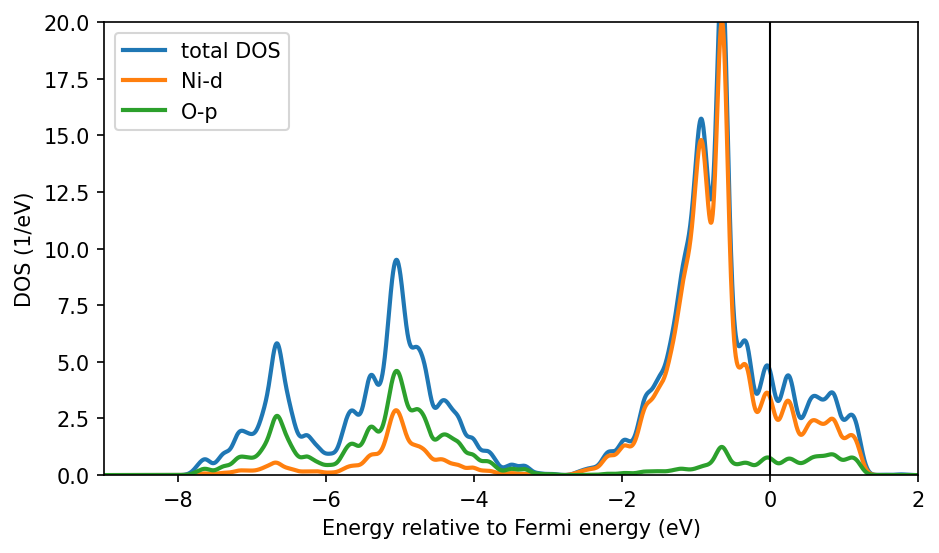

In [4]:
fig, ax = plt.subplots(1,dpi=150,figsize=(7,4))

ax.plot(vasprun.tdos.energies - vasprun.efermi , vasprun.tdos.densities[Spin.up], label=r'total DOS', lw = 2) 
ax.plot(vasprun.tdos.energies - vasprun.efermi , Ni_spd_dos[OrbitalType.d].densities[Spin.up], label=r'Ni-d', lw = 2) 
ax.plot(vasprun.tdos.energies - vasprun.efermi , O_spd_dos[OrbitalType.p].densities[Spin.up], label=r'O-p', lw = 2) 

ax.axvline(0, c='k', lw=1)
ax.set_xlabel('Energy relative to Fermi energy (eV)')
ax.set_ylabel('DOS (1/eV)')
ax.set_xlim(-9,2)
ax.set_ylim(0,20)
ax.legend()
plt.show()

## creating the hdf5 archive

now we run the Vasp converter to create an input h5 archive for the solver. The [plo.cfg](plo.cfg) looks like this: 

In [5]:
!cat plo.cfg

[General]
BASENAME = nio

[Group 1]
SHELLS = 1
EWINDOW = -9 2
NORMALIZE = True

[Shell 1] # Ni d shell
LSHELL = 2
IONS = 1 2
CORR = True



we create $d$ like projectors within a large energy window from -9 to 2 eV for very localized states for both Ni sites. Important: the sites are markes as non equivalent, so that we can later have different spin orientations on them. Next we run the converter:

In [6]:
# Generate and store PLOs
plo_converter.generate_and_output_as_text('plo.cfg', vasp_dir='./')

# run the archive creat routine
conv = VaspConverter('nio')
conv.convert_dft_input()

!!! WARNING !!!: Error reading E-Fermi from LOCPROJ, trying DOSCAR
Read parameters:
0  ->  {'label': 'dxy', 'isite': 1, 'l': 2, 'm': 0}
1  ->  {'label': 'dyz', 'isite': 1, 'l': 2, 'm': 1}
2  ->  {'label': 'dz2', 'isite': 1, 'l': 2, 'm': 2}
3  ->  {'label': 'dxz', 'isite': 1, 'l': 2, 'm': 3}
4  ->  {'label': 'dx2-y2', 'isite': 1, 'l': 2, 'm': 4}
5  ->  {'label': 'dxy', 'isite': 2, 'l': 2, 'm': 0}
6  ->  {'label': 'dyz', 'isite': 2, 'l': 2, 'm': 1}
7  ->  {'label': 'dz2', 'isite': 2, 'l': 2, 'm': 2}
8  ->  {'label': 'dxz', 'isite': 2, 'l': 2, 'm': 3}
9  ->  {'label': 'dx2-y2', 'isite': 2, 'l': 2, 'm': 4}
  Found POSCAR, title line: Ni2 O2
  Total number of ions: 4
  Number of types: 2
  Number of ions for each type: [2, 2]

    Total number of k-points: 729
  No tetrahedron data found in IBZKPT. Skipping...
eigvals from LOCPROJ

  Unorthonormalized density matrices and overlaps:
  Spin: 1
  Site: 1
  Density matrix                                                  Overlap
   1.6802167  -0

We note a few special things here. First, the density matrix off the d-shell seems to be quite off-diagonal. This is because in Vasp local projections are always done with respect to cartesian axis, and hence the unit cell is non cubic shaped the oxygen octahedra are rotated in the cell, leading to projection which is not strictly what we expect. We will correct for that in the next step when we run DMFT. Second, the in the end of each run we see how many inequivalent impurities are created, which is different for the two runs as expected. 

## running the high temperature PM calculation

he input file for solid_dmft looks as follows: 

In [7]:
!cat config_highT.ini

[general]
# use here h5 archive with 1 impurity problem
seedname = nio
jobname = NiO_highT

enforce_off_diag = False
block_threshold = 0.001
# rotate to diagonal orbital basis that corresponds to 
# normal d orbitals. Note, that Vasp does projections
# along cartesian axis, hence orbitals got mixed
set_rot = hloc

solver_type = cthyb
n_iw = 501 

prec_mu = 0.001

h_int_type = density_density
U = 8.0
J = 1.0

# temperature ~2200 K
beta = 5
# allow for magnetic order
magnetic = True
# make both sites equivalent but spin in the same direction 
magmom = 0.0001, 0.0001
afm_order = True

n_iter_dmft = 10

g0_mix_type = linear
g0_mix = 0.9

dc_type = 0
dc = True
dc_dmft = False

[solver]
length_cycle = 150
n_warmup_cycles = 10000
n_cycles_tot = 1e+7
# use new delta interface to reduce noise
delta_interface = True
imag_threshold = 1e-5
# cut off diag elements for simplicity
off_diag_threshold = 1e-3

perform_tail_fit = True
fit_max_moment = 4
fit_min_w = 6
fit_max_w = 10



we allow also for the high temperature calculation for a magnetic moment by setting `magnetic = True`. By setting the flag magmom to a small value with the same sign on both sites we tell solid_dmft that both sites are equivalent. We see in the low temperature example how we can use this to enfore a antiferromagnetic order. Now we run solid_dmft simply by `mpirun solid_dmft config_highT.ini` . Caution: this is a very heavy job and will take roughly 10 min on 256 mpi ranks. 

In the beginning of the calculation try to locate the following lines:

    AFM calculation selected, mapping self energies as follows:
    imp  [copy sigma, source imp, switch up/down]
    ---------------------------------------------
    0: [False, 0, False]
    1: [True, 0, False]

this tells us that solid_dmft detected correctly how we want to orientate the spin moments. This also reflects itself during the iterations when the second impurity problem should be solver. Instead of solving solid_dmft copies all properties of the first impurity and if neccessary flips the spin channel: 

    ...
    copying the self-energy for shell 1 from shell 0
    inverting spin channels: False
    ...

After the calculation is finished we can take a look at the results:

In [8]:
with HDFArchive('NiO_highT/nio.h5','r') as h5:
    Sigma_iw = h5['DMFT_results/last_iter/Sigma_freq_0']
    obs = h5['DMFT_results/observables']

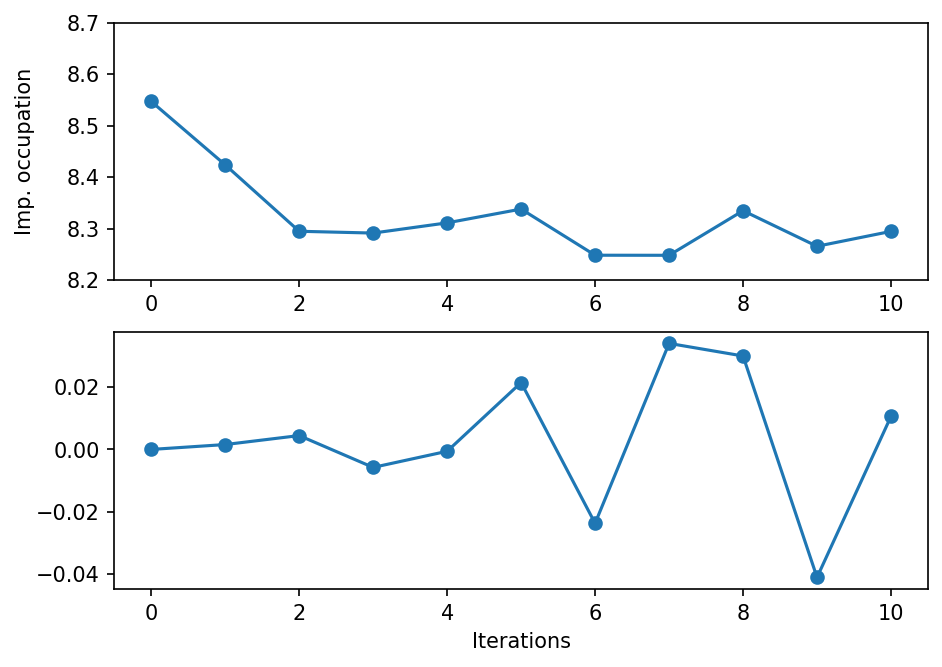

In [9]:
fig, ax = plt.subplots(nrows=2, dpi=150, figsize=(7,5))

ax[0].plot(obs['iteration'], np.array(obs['imp_occ'][0]['up'])+np.array(obs['imp_occ'][0]['down']), '-o')

ax[1].plot(obs['iteration'], (np.array(obs['imp_occ'][0]['up'])-np.array(obs['imp_occ'][0]['down'])), '-o')



ax[0].set_ylabel('Imp. occupation\n')
ax[0].set_ylim(8.2, 8.7)
ax[-1].set_xlabel('Iterations')

plt.show()

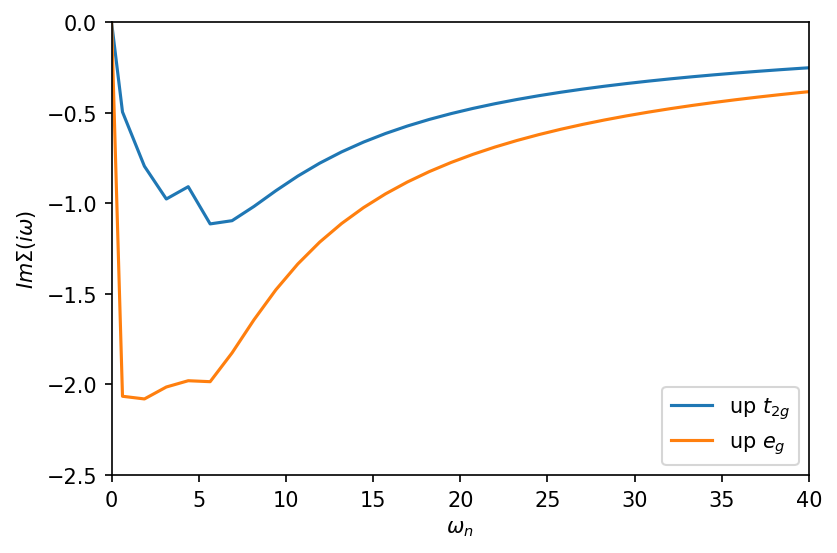

In [10]:
fig, ax = plt.subplots(1,dpi=150)

ax.oplot(Sigma_iw['up_0'][0,0].imag, '-', label=r'up $t_{2g}$')
ax.oplot(Sigma_iw['up_0'][1,1].imag, '-',label=r'up $e_{g}$')

ax.set_ylabel(r"$Im \Sigma (i \omega)$")

ax.set_xlim(0,40)
ax.set_ylim(-2.5,0)
ax.legend()
plt.show()

In [18]:
with HDFArchive('NiO_lowT/nio.h5','r') as h5:
    Sigma_iw = h5['DMFT_results/it_5/Sigma_freq_0']
    obs = h5['DMFT_results/observables']

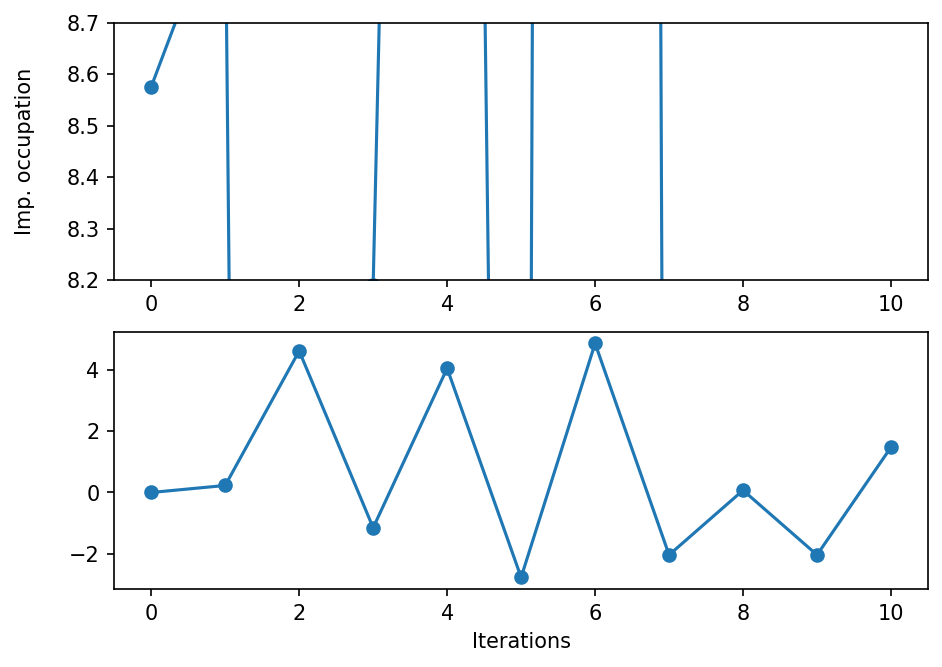

In [19]:
fig, ax = plt.subplots(nrows=2, dpi=150, figsize=(7,5))

ax[0].plot(obs['iteration'], np.array(obs['imp_occ'][0]['up'])+np.array(obs['imp_occ'][0]['down']), '-o')

ax[1].plot(obs['iteration'], (np.array(obs['imp_occ'][0]['up'])-np.array(obs['imp_occ'][0]['down'])), '-o')



ax[0].set_ylabel('Imp. occupation\n')
ax[0].set_ylim(8.2, 8.7)
ax[-1].set_xlabel('Iterations')

plt.show()

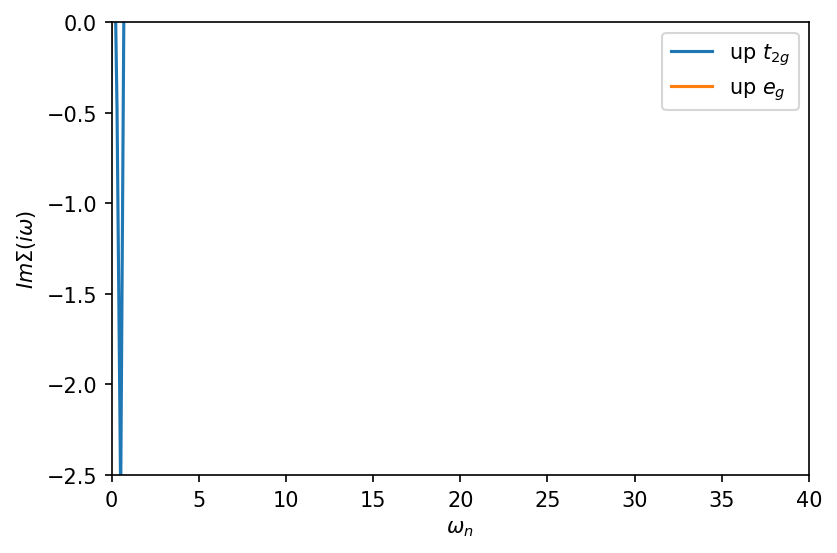

In [20]:
fig, ax = plt.subplots(1,dpi=150)

ax.oplot(Sigma_iw['up_0'][0,0].imag, '-', label=r'up $t_{2g}$')
ax.oplot(Sigma_iw['up_0'][1,1].imag, '-',label=r'up $e_{g}$')

ax.set_ylabel(r"$Im \Sigma (i \omega)$")

ax.set_xlim(0,40)
ax.set_ylim(-2.5,0)
ax.legend()
plt.show()